<a href="https://colab.research.google.com/github/BramanTyamahedrawan/Machine-Learning-SMT-5/blob/main/pertemuan-10/Praktikum_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NAMA      : BRAMAN TYAMAHENDRAWAN**

**KELAS     : TI-3C**

**NIM       : 2141720097**

# **Praktikum 1 - Pertemuan 10**

**RNN untuk Analisis Sentimen**

In [ ]:
# Impor matplotlib dan buat fungsi pembantu untuk memplot grafik
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

**Setup input pipeline**

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Awalnya ini mengembalikan dataset (teks, pasangan label)
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
# Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label)
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This should be required viewing for all young people. This is documentary at its best, from the haunting music and terrific narration by Olivier to its unflinching and penetrating analyses, The World at War is unforgettable and irreplaceable for anyone who wants to know about humanity's sorry experience at the nadir of the 20th century."
 b'Unless somebody enlightens me, I really have no idea what this movie is about. It looks like a picture with a message but it\xc2\xb4s far from it. This movie tells pointless story of a New York press agent and about his problems. And, that\xc2\xb4s basically all. When that agent is played by Pacino, one must think that it must be something important. But it takes no hard thinking to figure out how meaningless and dull this movie is. To one of the best actors in the world, Al Pacino, this is the second movie of the year (the other is "Simone") that deserves the title "the most boring and the most pointless motion picture of the year". So, 

**Buat Teks Encoder**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# Metode .adapt mengatur kosakata lapisan. 20 token pertama
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
# Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11, 139,  28, ...,   0,   0,   0],
       [893,   1,   1, ...,   0,   0,   0],
       [  1,   1,   5, ...,   0,   0,   0]])

In [ ]:
# Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This should be required viewing for all young people. This is documentary at its best, from the haunting music and terrific narration by Olivier to its unflinching and penetrating analyses, The World at War is unforgettable and irreplaceable for anyone who wants to know about humanity's sorry experience at the nadir of the 20th century."
Round-trip:  this should be [UNK] viewing for all young people this is documentary at its best from the [UNK] music and [UNK] [UNK] by [UNK] to its [UNK] and [UNK] [UNK] the world at war is [UNK] and [UNK] for anyone who wants to know about [UNK] sorry experience at the [UNK] of the [UNK] [UNK]                                                                                                                                                                                                                                                                                                                                                                

**Buat Model**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[-0.00794028]


In [ ]:
# evaluasi lagi dalam batch dengan kalimat yang lebih panjang
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 367ms/step
[-0.00794028]


In [ ]:
# compile model Keras untuk mengonfigurasi proses pelatihan
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Epoch 1/10
391/391 [==============================] - 736s 2s/step - loss: 0.6241 - accuracy: 0.5892 - val_loss: 0.4735 - val_accuracy: 0.7667
Epoch 2/10
391/391 [==============================] - 715s 2s/step - loss: 0.3873 - accuracy: 0.8221 - val_loss: 0.3594 - val_accuracy: 0.8323
Epoch 3/10
391/391 [==============================] - 713s 2s/step - loss: 0.3357 - accuracy: 0.8515 - val_loss: 0.3477 - val_accuracy: 0.8578
Epoch 4/10
391/391 [==============================] - 692s 2s/step - loss: 0.3205 - accuracy: 0.8603 - val_loss: 0.3373 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 682s 2s/step - loss: 0.3123 - accuracy: 0.8656 - val_loss: 0.3384 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 677s 2s/step - loss: 0.3087 - accuracy: 0.8663 - val_loss: 0.3306 - val_accuracy: 0.8448
Epoch 7/10
391/391 [==============================] - 687s 2s/step - loss: 0.3040 - accuracy: 0.8687 - val_loss: 0.3370 - val_accuracy: 0.8401

In [ ]:
# Jalankan prediksi pada kalimat baru
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


**Stack two or more LSTM layersl**

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :

*   Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
*   Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1459s 4s/step - loss: 0.6190 - accuracy: 0.5989 - val_loss: 0.4308 - val_accuracy: 0.8167
Epoch 2/10
391/391 [==============================] - 1375s 4s/step - loss: 0.3903 - accuracy: 0.8324 - val_loss: 0.3552 - val_accuracy: 0.8411
Epoch 3/10
391/391 [==============================] - 1361s 3s/step - loss: 0.3388 - accuracy: 0.8597 - val_loss: 0.3337 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 1346s 3s/step - loss: 0.3223 - accuracy: 0.8631 - val_loss: 0.3309 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 1358s 3s/step - loss: 0.3138 - accuracy: 0.8656 - val_loss: 0.3221 - val_accuracy: 0.8516
Epoch 6/10
391/391 [==============================] - 1356s 3s/step - loss: 0.3072 - accuracy: 0.8680 - val_loss: 0.3657 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 1357s 3s/step - loss: 0.3011 - accuracy: 0.8736 - val_loss: 0.3236 - val_accuracy:

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 323s 826ms/step - loss: 0.3173 - accuracy: 0.8590
Test Loss: 0.31732264161109924
Test Accuracy: 0.858959972858429


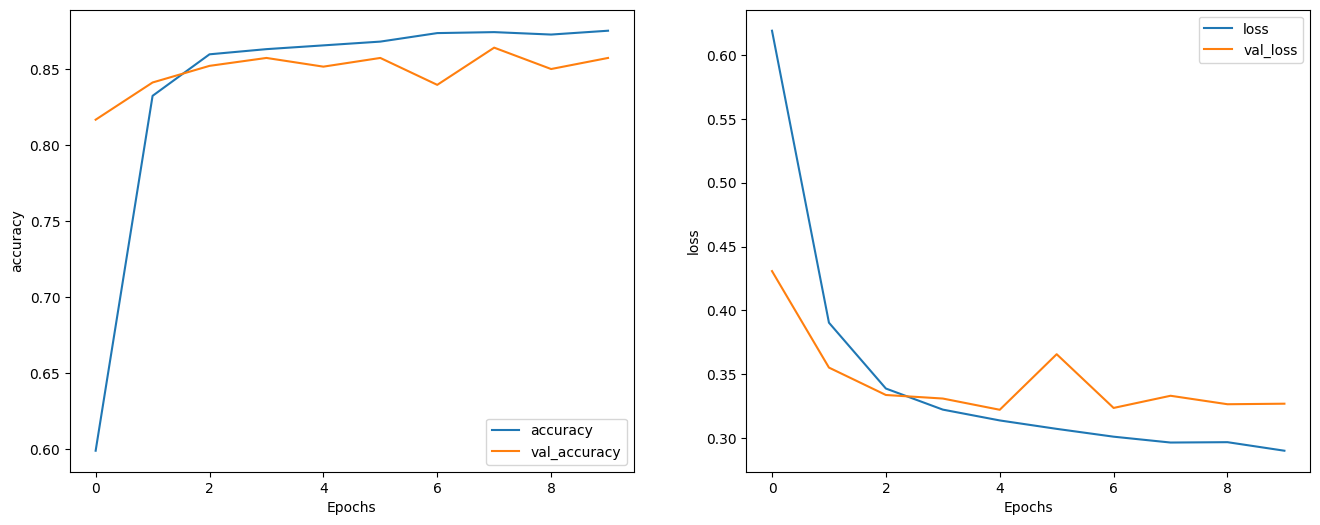

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# **Praktikum 2 - Pertemuan 10u**

**Setup**

In [25]:
# Import TensorFlow
import tensorflow as tf
import numpy as np
import os
import time

In [26]:
# Download Dataset Shakespeare
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [27]:
# Load Data
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [28]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [29]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Olah Teks**

In [30]:
# Vectorize Teks
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [31]:
# sekarang buat tf.keras.layers.StringLookup layer:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

In [32]:
# perintah diatas mengconvert token menjadi id
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [33]:
# kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode get_vocabulary()
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [34]:
# Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor
chars = chars_from_ids(ids)
chars


<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [35]:
# Anda dapat menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [36]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [37]:
# Prediksi
# mengonversi vektor teks menjadi aliran indeks karakter.
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [38]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [39]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

seq_length = 100


F
i
r
s
t
 
C
i
t
i


In [40]:
# Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [41]:
# akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())


b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [42]:
# fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

split_input_target(list("Tensorflow"))
dataset = sequences.map(split_input_target)

In [43]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [44]:
# Membuat Batch Training
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**Buat Model**


Bagian ini mendefinisikan model sebagai subkelas keras.Model (untuk lebih detilnya, lihat Making new Layers and Models via subclassing).

**Model yang kita bangun memiliki 3 lapisan neural network :**


*   tf.keras.layers.Embedding: Lapisan masukan. Tabel pencarian yang dapat dilatih yang akan memetakan setiap karakter-ID ke vektor dengan dimensi embedding_dim;
*   tf.keras.layers.GRU: lapisan RNN dengan ukuran unit=rnn_units (Anda juga dapat menggunakan lapisan LSTM di sini.)
*   tf.keras.layers.Dense: Lapisan keluaran, dengan keluaran vocab_size. Ini menghasilkan satu logit untuk setiap karakter dalam kosakata. Ini adalah log kemungkinan setiap karakter menurut model.

In [45]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [46]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [47]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

**Uji Model**

In [48]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [49]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [50]:
sampled_indices

array([ 0, 30, 28, 31, 22,  0, 15, 39, 32, 64, 30, 29, 39, 29, 20, 22, 37,
       11, 29,  7, 19, 24, 49,  2,  4, 28, 51, 33, 26, 29,  2, 11, 55, 49,
       36, 34, 14, 49, 44, 61, 26, 25, 29, 50, 27, 27, 34, 53, 18, 11, 32,
       58, 16, 40, 24, 33, 24, 62,  9, 38, 37, 22, 15, 43, 36, 45,  8, 25,
       25, 53, 37, 57, 47, 58, 56, 53, 37, 14, 17, 30, 40, 15, 61, 37, 12,
       48, 55, 10, 45, 25, 21, 29, 50, 29, 42, 10, 37, 65, 42, 43])

In [51]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'he root\nFrom whence that tender spray did sweetly spring,\nI mean our princely father, Duke of York.\n'

Next Char Predictions:
 b'[UNK]QORI[UNK]BZSyQPZPGIX:P,FKj $OlTMP :pjWUAjevMLPkNNUnE:SsCaKTKw.YXIBdWf-LLnXrhsqnXADQaBvX;ip3fLHPkPc3Xzcd'


**Train Model**

In [52]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [53]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.190715, shape=(), dtype=float32)


In [54]:
tf.exp(example_batch_mean_loss).numpy()

66.07

In [55]:
model.compile(optimizer='adam',loss=loss)

In [56]:
# Konfigurasi Checkpoints
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [57]:
# Lakukan Proses Training
EPOCHS = 20

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 1013s 6s/step - loss: 2.7409
Epoch 2/20
172/172 [==============================] - 1000s 6s/step - loss: 2.0009
Epoch 3/20
 57/172 [========>.....................] - ETA: 11:10 - loss: 1.7936

KeyboardInterrupt: ignored

**Generate Teks**

Cara termudah untuk menghasilkan teks dengan model ini adalah dengan menjalankannya dalam loop, dan menyimpan status internal model saat Anda menjalankannya.

Setiap kali Anda memanggil model, Anda memasukkan beberapa teks dan state internal. Model mengembalikan prediksi untuk karakter berikutnya dan state barunya. Masukkan kembali prediksi dan state ke model untuk terus menghasilkan teks.

In [ ]:
# Berikut ini membuat prediksi satu langkah
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
# Karena sedikitnya jumlah epoch pelatihan, model belum belajar membentuk kalimat runtut.
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

In [ ]:
# model menghasilkan 5 keluaran dalam waktu yang hampir sama dengan waktu yang dibutuhkan untuk menghasilkan 1 keluaran di atas.
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

**Ekspor Model Generator**

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))